# Parameter Identifiability

If you wish to infer the parameters of a model from data, it would be useful to ensure the parameters can be reliably inferred. If not then the results and any further analysis could be significantly affected and not reproducible. In this notebook, I will teach you how to determine parameter identifiability by going through an example.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate, optimize

image_file = "../Images/parameter_identifiability/"

## The model

The example I will be using throughout this notebook is a two-compartment Pharmacokinetic (PK) model. PK models are mathematical models of the concentration of the drug throughout the body over time. In the two-compartment model the body is abstracted into a central compartment (that encompasses blood plasma) and a peripheral compartment. At time $t=0$, the drug is injected straight into the central compartment. Over time, the drug is then transferred between the central and peripheral compartments, and is also cleared from the central compartment. This model is given by the following system of ordinary differential equations (ODEs),
        \begin{align*}
        \dot{A_c} =& - K_\textrm{cl}\frac{A_c}{V_c} - K_i\left(\frac{A_c}{V_c} - \frac{A_p}{V_p}\right),\\
        \dot{A_p} =& K_p\left(\frac{A_c}{V_c} - \frac{A_p}{V_p}\right),
        \end{align*}
where $A_c$ and $A_p$ are the masses of drug in the central and peripheral compartments, respectively, $V_c$ and $V_p$ are the volumes of the central and peripheral compartments, respectively, $K_\textrm{cl} >0$ is the rate of clearance from the central compartment and $K_p >0$ is the rate of transfer between the central compartment and the peripheral compartment. Our first step is to build a class with a function that takes a time series and list of parameter values as input and outputs the time course of $C_c = A_c/V_c$.

In [2]:
class PKLin2Comp():
    def __init__(self, dose):
        self.n_parameters = 4
        self.dose = dose
        self.params = None
        
    def set_params(self, parameter):
        self.params = {
            "V_c": parameter[0],
            "K_cl": parameter[1],
            "V_p": parameter[2],
            "K_p": parameter[3]
        }
        
    
    def ODE(self, A, t):
        """
            Takes the current amount of drug, A, in the compartments and time, t, and returns dA_dt
        """
        dA_c_dt = (
            self.params["K_p"]*(A[1]/self.params["V_p"]) -
            (self.params["K_p"]+self.params["K_cl"])*(A[0]/self.params["V_c"])
        )
        dA_p_dt = (
            self.params["K_p"]*((A[0]/self.params["V_c"]) - (A[1]/self.params["V_p"]))
        )

        dA_dt = np.asarray([dA_c_dt, dA_p_dt])

        return dA_dt
    
    
    def solve(self, times):
        """
            Solves the PK system of ODEs
        """
        
        # Set the initial condition.
        A_0 = [self.dose, 0]

        # Get the solution to the ODEs
        results_amt = integrate.odeint(
            self.ODE,
            A_0,
            times,
#             rtol=1.49012e-12,
#             atol=1.49012e-12
#             hmax = 1e-4
            )

        # Convert amount of drug to concentration of drug
        results_conc = results_amt/np.asarray([self.params["V_c"], self.params["V_p"]])
        return results_conc
    
    def simulate(self, parameter, times):
        """
            Returns the concentration of drug over time, given a set of parameters. Assumes that dosing happens at time t=0
        """
        
        self.set_params(parameter)
        
        if times[0] == 0:
            return self.solve(times)[:]
        elif times[0] > 0:  
            # If the times do not start at 0 then odeint will begin simulation at the first timepoint.
            # However our model assumes dosing happens at t=0 so we will need to add 0 to the times array and
            # then ignore the result at t=0.
            times = np.concatenate((np.array([0]), times))
            return self.solve(times)[1:]
        elif times[0] < 0:  
            # If the times start before t=0 then we will need to return 0 for all the negative time points and
            # then start the simulation after those.
            times_after_zero = times[times >= 0]
            zeros = np.zeros((len(times) - len(times_after_zero), 2))
            times_after_zero = np.concatenate((np.array([0]), times_after_zero))
            
            return np.concatenate((zeros, self.solve(times_after_zero)[1:]))

Now that the model has been built, we can see what the resulting concentration-time profiles of this model are.

<ipython-input-3-2711ec517093>:25: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


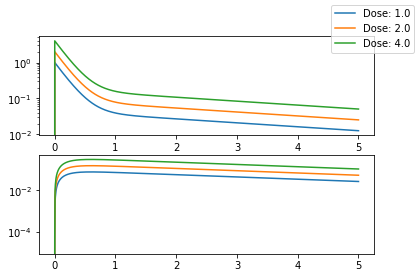

In [3]:
doses = [1.0, 2.0, 4.0] # mg
PK_param_names = ["V_c", "K_cl", "V_P", "K_p"]
PK_param_value = [1,     2.8,    4.8,   2.3]

fig, ax = plt.subplots(2, 1)
times = np.linspace(-0.01, 5, 1000)

for dose in doses:
    PK_model = PKLin2Comp(dose)
    solution = PK_model.simulate(PK_param_value, times)
    
    ax[0].plot(
        times,
        solution[:, 0],
        label='Dose: '+str(dose)
        )
    ax[1].plot(
        times,
        solution[:,1],
        )

ax[0].set_yscale("log")
ax[1].set_yscale("log") # It is easier to view the graph on a log scale
fig.legend()
fig.show()

## The data

If you are performing parameter inference, this requires data to infer the parameters from. This data is also used in parameter identifiability. For this example, I will generate some data from the model to use in place of experimental data. In experiments the observation is usually of the concentration of drug in the blood stream and so we are only concerned with the central compartment.

In [4]:
dose_amount = 2.0

PK_model = PKLin2Comp(dose_amount)
data_times = np.linspace(0.1, 5, 5) # In vivo PK data tends to be very sparse
values_no_noise = PK_model.simulate(PK_param_value, data_times)[:,0]

# We will use multiplicative gaussian noise to generate to data as that is commonly seen in experimental PK data
sigma = 0.1
noise = np.random.normal(0, sigma, len(data_times))
values_noisey = values_no_noise*(1+noise)

# df = pd.read_csv("../Data_and_parameters/PK_sim/sythesised_data_real_timepoints.csv")
df = pd.DataFrame()
df["TIME"] = data_times
df["OBS"] = values_noisey
df

,TIME,OBS
0,0.100,1.138352
1,1.325,0.063106
2,2.550,0.040895
3,3.775,0.033426
4,5.000,0.023547


We can also visualise the data on a graph:

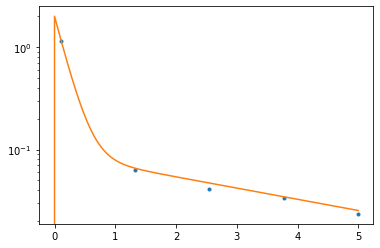

In [5]:
# dose_amount = 2.0
# PK_model = PKLin2Comp(dose_amount)

more_times = np.linspace(-0.01, max(data_times),1000)
more_values = PK_model.simulate(PK_param_value, more_times)[:,0]

plt.plot(df["TIME"], df["OBS"], '.')
plt.plot(more_times, more_values)
plt.yscale("log")

## Maximum likelihood

A common approach to parameter inference is to maximise the probability the data, $X^{obs}$, was generated by the model with parameters, $\theta \in \Theta$, over the parameter space $\Theta$. This probability, $P\left(X^{obs}|\theta\right)$, is called the likelihood. Let's test whether the parameters of our PK model, $\theta = (V_c, K_{cl}, V_P, K_p, \sigma)$, are similarly inferred each time we run the simulation. 

First we need to define the likelihood. For this example, I will use a multiplicative gaussian likelihood as multiplicative noise was used to generate the data. In most caes we will not know the exact type of noise present in a data set and so some assumptions will need to be made. The Likelihood can be calculated as the product of point-wise likelihoods,
\begin{equation*}
    P\left(X^\textrm{obs}|\theta\right) = \prod_{x^{obs}_i \in X^\textrm{obs}} P\left(x^{obs}_i|\theta\right).
\end{equation*}
Alternatively, a computationally easier but equivalent optimisation is the log-likelihood,
\begin{equation*}
    \log\left(P\left(X^\textrm{obs}|\theta\right)\right) = \sum_{x^{obs}_i \in X^\textrm{obs}} \log\left(P\left(x^{obs}_i|\theta\right)\right),
\end{equation*}
As we are using a multiplicative Gaussian noise, each of these pointwise observations are expected to be normally distributed around the true value, $\mu_i$, i.e.  $x^{obs}_i \sim N\left(\mu_i, \sigma_i^2\right)$ where $\sigma_i$ is the standard deviation of the observation at time $t=t_i$. Thus the pointwise likelihood can be formulated as a Gaussian distribution,
\begin{align*}
    P\left(x^{obs}_i|\theta\right) &= P\left(x^{obs}_i|\mu_i = x^{\theta}\left(t_i\right), \sigma_i = \sigma x^\theta\left(t_i\right)\right) \\
    &= \frac{1}{\sigma x^\theta\left(t_i\right)\sqrt{2\pi}}e^{-\frac{1}{2}\left(x^{obs}_i - x^\theta\left(t_i\right)\right)^2\left(\sigma x^\theta\left(t_i\right)\right)^{-2} },
\end{align*}
where $x^{\theta}$ is the simulated dynamical model under parameters $\theta$. Thus the log-likelihood is 
\begin{align*}
    \log \left(P\left(X^{obs}|\theta\right)\right) &= \sum_{x^{obs}_i \in X^\textrm{obs}} \left(-\frac{1}{2}\log\left(2\pi\right) -\log\left(\sigma x^\theta\left(t_i\right)\right) -\frac{1}{2}\left(\frac{x^{obs}_i - x^\theta\left(t_i\right)}{\sigma x^\theta\left(t_i\right)}\right)^2\right).
\end{align*}

So now let's build a function that returns this likelihood. Our optimisation algorithm finds the minimum of a function and so our function neeeds to return $-\log \left(P\left(X^{obs}|\theta\right)\right)$ as the minimum of this is the maximum of the log-likelihood.

In [6]:
def minus_log_likelihood(parameters, times, observations):
    sigma = parameters[-1]
    n_obs = len(times)
    x_theta = PK_model.simulate(parameters[:-1], times)[:,0]
    if any(x_theta<=0):
        x_theta[x_theta<=0] = 1e-20 # Numerical errors can turn up negative results which affects likelihood calculation
    term_1 = 0.5*n_obs*np.log(2*np.pi)
#     print(term_1)
    term_2 = np.sum(np.log(sigma*x_theta))
#     print(sigma*x_theta)
    term_3 = (0.5/sigma**2) * np.sum((observations - x_theta)**2/x_theta**2)
#     print(term_3)
    log_likelihood = term_1 + term_2 + term_3
    return log_likelihood
print("Log-Likelihood of parameters theta =", PK_param_value+[sigma], "is", -minus_log_likelihood(PK_param_value+[sigma], df["TIME"], df["OBS"]))

Log-Likelihood of parameters theta = [1, 2.8, 4.8, 2.3, 0.1] is 18.07811061317265


Using the first two points in the data we can make an initial estimate in the value of $V_c$. We can then use this to help our optimiser narrow into the correct value quicker.

In [7]:
point_1 = (df['TIME'][0], df['OBS'][0])
point_2 = (df['TIME'][1], df['OBS'][1])
y_0 = point_1[1] - (point_1[1] - point_2[1])/(point_1[0] - point_2[0]) * point_1[0]
V_c_approx = dose_amount/y_0
print("Aproximate V_C:", V_c_approx)

Aproximate V_C: 1.6311528933578443


Now to optimise. We will use the global optimiser difeferential evolution.

In [8]:
#Set the boundaries of the search space
bounds = [
    (0.1*V_c_approx, 10*V_c_approx), # V_c
    (0.01, 100),  # K_cl
    (0.01*V_c_approx, 100*V_c_approx),  # V_p
    (0.01, 100),  # K_p
    (0.0001, 1)  # sigma
]

# Now lets optimize 5 times and see what the outcome of each optimisation is. This can take a little bit of time.
results = []
for i in range(0,5):
    optimum = optimize.dual_annealing(minus_log_likelihood, bounds, args = (df["TIME"], df["OBS"]))
    results.append(np.concatenate((optimum.x, [-optimum.fun])))
    print("Run", i, "optimum:", optimum.x, ", log likelihood:", -optimum.fun)

Run 0 optimum: [1.20055095 2.7520297  4.73483576 1.86977818 0.0277156 ] , log likelihood: 23.80945705214729
Run 1 optimum: [0.5587103  3.21315163 6.16652561 3.33129422 0.04151142] , log likelihood: 21.78710388930238
Run 2 optimum: [1.20055206 2.7520288  4.73482783 1.86977334 0.02771562] , log likelihood: 23.809457050685975
Run 3 optimum: [1.20055145 2.75202928 4.73483506 1.86977752 0.02771572] , log likelihood: 23.80945705209602
Run 4 optimum: [1.20055234 2.75202837 4.73483759 1.8697764  0.02771572] , log likelihood: 23.809457051825078


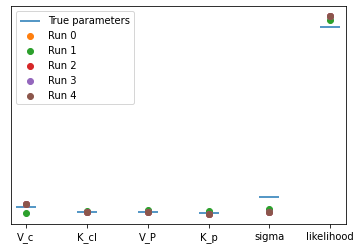

In [10]:
ll_true = -minus_log_likelihood(PK_param_value+[sigma], df["TIME"], df["OBS"])
l_bound = np.concatenate((np.asarray(bounds)[:,0], [ll_true-100]))
u_bound = np.concatenate((np.asarray(bounds)[:,1], [ll_true+10]))

rel_position = (np.asarray(PK_param_value+[sigma]+[ll_true])-l_bound)/(u_bound-l_bound)
plt.scatter(
    PK_param_names+["sigma"]+["likelihood"], 
    rel_position, 
    label="True parameters", 
    marker="_", 
    s=20 ** 2
)

for i, optimum in enumerate(results):
    rel_position = (optimum-l_bound)/(u_bound-l_bound)
    plt.scatter(PK_param_names+["sigma"]+["likelihood"], rel_position, label = "Run "+str(i))
plt.legend()
plt.yticks([], [])
plt.show()

The above optimisations may differ from one another and can give an indication on whether this is identifiable or not. However, this is does not definitively inform us how identifiable any of the parameters are. As this optimisation algorithm has stochastic processes, by chance it may have all found the same local minima or different ones.

## Profile likelihood

To determine Parameter Identifiability we can examine the profile likelihoods of the parameters. To do this, each parameter is varied around the optimised value, and the log-likelihood for the other parameters re-optimised, i.e.:
\begin{equation}
    PL\left(\theta_i\right) = \max_{\theta_{-i}}\left(\log\left(P\left(X^\textrm{obs} | \theta_i, \theta_{-i}\right)\right)\right)
\end{equation}
for each parameter $\theta_i$, where $\theta_{-i}$ are all parameters excluding $\theta_i$. This is then compared with a vertical confidence line where the intersection of this line to the profile likelihood curve indicates the confidence interval. For a confidence interval of 95\% a confidence line at 1.92 below the maximum is used. If the curve acquired from $PL\left(\theta_i\right)$ does not cross the confidence line on one or both sides of the maximum then the parameters are unidentifiable. We have already performed a global optimisation, we can use this as the starting point for subsequent optimisations.

In [11]:
# Excluding run 1 as this was an outlier in my case, change for your runs.
exclude_outliers = np.asarray(results[0:1]+results[2:])
start_point = np.average(exclude_outliers[:,:-1], axis=0)

print('Initial point for profile likelihood')
for i in range(0,len(PK_param_names)):
    print(PK_param_names[i] + " = " + str(start_point[i]))

Initial point for profile likelihood
V_c = 1.2005516997474874
K_cl = 2.7520290392626423
V_P = 4.7348340607814015
K_p = 1.8697763598630708


Now to define the algorithm that will perform the optimisation.

In [12]:
def single_profile_loglikelihood(param_index, param_range, point_start):
    likelihood = []
    point = point_start
    PL_bounds = bounds.copy()
    i=0
    
    for theta_i in param_range:
        PL_bounds[param_index] = (theta_i, theta_i) # ensure the parameter theta_i is fixed in the optimisation
        point[param_index] = theta_i

        opt = optimize.minimize(minus_log_likelihood, point, bounds=PL_bounds, args = (df["TIME"], df["OBS"]))
        
        print(
            "\r", 
            str(int(i/len(param_range)*100))
            + "% complete",
            sep=' ', 
            end='', 
            flush=True
        )
        i+=1
        
                
        point = opt.x
        loglike = -opt.fun
        likelihood.append([theta_i, loglike])
    return likelihood

likelihoods = {}
for param_index in range(0, 5):
    print("\n Profile likelihood for " + (PK_param_names+["sigma"])[param_index]+ " lower:")
    n=0
    param_range = np.linspace(1*start_point[param_index], 0.5*start_point[param_index], 100)
    likelihood_lower = single_profile_loglikelihood(param_index, param_range, start_point)
    likelihood_lower.reverse()
    print("\n Profile likelihood for " + (PK_param_names+["sigma"])[param_index]+ " upper:")
    
    param_range = np.linspace(1*start_point[param_index], 1.5*start_point[param_index], 100)
    likelihood_upper = single_profile_loglikelihood(param_index, param_range, start_point)
    likelihoods[param_index] = np.asarray(likelihood_lower + likelihood_upper)
    
#     n+=1
#     param_range = np.linspace(1*opt_point_comb[param_index], 1.5*opt_point_comb[param_index], 100)
#     likelihood_upper = single_profile_loglikelihood(param_index, param_range, point)
    
#     likelihood_lower.reverse()
#     likelihood = np.array(likelihood_lower+likelihood_upper)


 Profile likelihood for V_c lower:
 9% complete

/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx


 99% complete
 Profile likelihood for V_c upper:
 99% complete88% complete
 Profile likelihood for K_cl lower:
 99% complete45% complete56% complete93% complete95% complete98% complete
 Profile likelihood for K_cl upper:
 99% complete21% complete35% complete43% complete74% complete
 Profile likelihood for V_P lower:
 99% complete% complete90% complete
 Profile likelihood for V_P upper:
 99% complete35% complete63% complete64% complete68% complete72% complete
 Profile likelihood for K_p lower:
 99% complete35% complete93% complete
 Profile likelihood for K_p upper:
 99% complete14% complete30% complete62% complete70% complete
 Profile likelihood for sigma lower:
 99% complete56% complete78% complete
 Profile likelihood for sigma upper:
 99% complete

<ipython-input-13-5dbf506659e0>:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


[(0.16311528933578445, 16.311528933578444), (0.01, 100), (0.016311528933578442, 163.11528933578444), (0.01, 100), (0.0001, 1)] [1.2005517  2.75202904 4.73483406 1.86977636 0.02771566] [1, 2.8, 4.8, 2.3, 0.1]


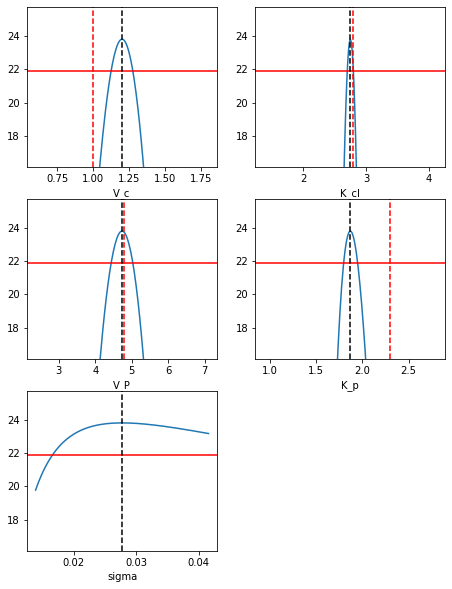

In [13]:
fig, ax = plt.subplots(3, 2)
param_values = PK_param_value + [sigma]
fig.set_size_inches(7.5, 10)

#Mechanistic Parameters
for i in range(0,5):
    likelihood = likelihoods[i]
    ax[int(i/2), i%2].plot(likelihood[:,0], likelihood[:,1])
    ax[int(i/2), i%2].axhline(y=np.max(likelihood[:,1])-(3.84/2), linestyle='-', color='r')
    ax[int(i/2), i%2].axvline(x=start_point[i], linestyle='--', color='black')
    if (param_values[i]<np.max(likelihood[:,0]) and param_values[i]>np.min(likelihood[:,0])):
        ax[int(i/2), i%2].axvline(x=param_values[i], linestyle='--', color='red')
        
    ax[int(i/2), i%2].set_xlabel((PK_param_names+["sigma"])[i])
    ax[int(i/2), i%2].set_ylim([np.max(likelihood[:,1])-(3.84*2), np.max(likelihood[:,1])+1.92])

#     ax[int(i/2), i%2].set_xscale("log")


ax[2, 1].set_axis_off()
fig.show()

As we can see here $\sigma$ seems to be unidentifiable. If we observe it over the full width of boundaries. 


 Profile likelihood for sigma lower:
 99% complete48% complete89% complete94% complete
 Profile likelihood for sigma upper:
 99% complete30% complete90% complete93% complete96% complete

/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx


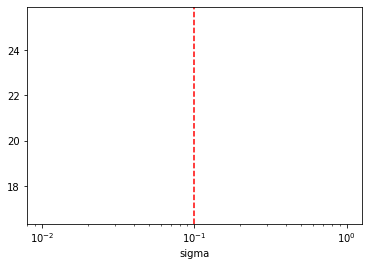

In [22]:
print("\n Profile likelihood for " + "sigma"+ " lower:")
param_range = np.linspace(1*start_point[4], 0.5*start_point[4], 100)
likelihood_lower = single_profile_loglikelihood(4, param_range, start_point)
likelihood_lower.reverse()

print("\n Profile likelihood for " + "sigma"+ " upper:")
param_range = np.logspace(np.log(1*start_point[4]), np.log(np.asarray(bounds)[4, 1]), 100)
likelihood_upper = single_profile_loglikelihood(4, param_range, start_point)
likelihood = np.asarray(likelihood_lower)


plt.plot(likelihood[:,0], likelihood[:,1])
plt.axhline(y=np.max(likelihood[:,1])-(3.84/2), linestyle='-', color='r')
plt.axvline(x=start_point[4], linestyle='--', color='black')
plt.axvline(x=param_values[4], linestyle='--', color='red')
plt.xlabel("sigma")
plt.ylim([24-(3.84*2), 24+1.92])

plt.xscale("log")
plt.show()